# Upload model_weights2.h5 file to working directory files then enter kaggle username and key for dataset 
```kaggle Key: a70a5b08c43376f78fda9fa4b9033fa5```

# [Lime intoroduction](https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b) 
### Feature importance is often used to determine which features play an important role in the model predictions. Random forests provide an out-of-the-box method to determine the most important features in the dataset and a lot of people rely on these feature importance's, interpreting them as a ‘ground truth explanation’ of the dataset.
### LIME is model-agnostic, meaning that it can be applied to any machine learning model. The technique attempts to understand the model by perturbing the input of data samples and understanding how the predictions change.
### Model-specific approaches aim to understand the black model machine learning model by analysing the internal components and how they interact. In deep learning models, it is e.g. possible to investigate activation units and to link internal activations back to the input. This requires a thorough understanding of the network and doesn’t scale to other models.
### LIME provides local model interpretability. LIME modifies a single data sample by tweaking the feature values and observes the resulting impact on the output. Often, this is also related to what humans are interested in when observing the output of a model. The most common question is probably: why was this prediction made or which variables caused the prediction?
### Other model interpretability techniques only answer the question above from the perspective of the entire dataset. Feature importance’s explain on a dataset level which features are important. It allows you to verify hypotheses and whether the model is overfitting to noise, but it is hard to diagnose specific model predictions.



```The output of LIME is a list of explanations, reflecting the contribution of each feature to the prediction of a data sample. This provides local interpretability, and it also allows to determine which feature changes will have most impact on the prediction. An explanation is created by approximating the underlying model locally by an interpretable one. Interpretable models are e.g. linear models with strong regularisation, decision tree’s, etc. The interpretable models are trained on small perturbations of the original instance and should only provide a good local approximation. The ‘dataset’ is created by e.g. adding noise to continuous features, removing words or hiding parts of the image. By only approximating the black-box locally (in the neighborhood of the data sample) the task is significantly simplified.```

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

In [3]:
od.download("https://www.kaggle.com/datasets/ahemateja19bec1025/facemask-dataset",data_dir="dataset")

Skipping, found downloaded files in "dataset/facemask-dataset" (use force=True to force download)


In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   validation_split = 0.2)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/dataset/facemask-dataset/dataset/dataset',
                                                   class_mode = 'binary',
                                                   color_mode="rgb",
                                                    subset="training",
                                                     target_size = (224,224),
                                                   classes={'1': 0,'0': 1})

Found 1101 images belonging to 2 classes.


In [6]:
from keras.models import load_model
def Build(model_weights_file):

        # load weights into the new model
        model = load_model(model_weights_file)
        return model
model=Build("model_weights2.h5")

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

1/1 [==============================] - 3s 3s/step


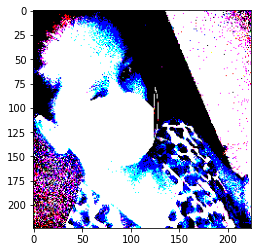

[[0.8937423]]


In [8]:
pred=model.predict(train_dataset[0][0][0].reshape(1,224,224,3))
plt.imshow(train_dataset[0][0][0])
plt.show()
print(pred)

In [9]:
!pip install lime

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer() 

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, 'IDC: mask')

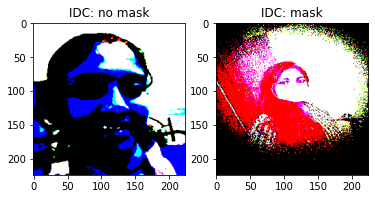

In [10]:
# two testing samples to be explained
plt.subplot(1, 2, 1)

IDC_0_sample_idx = train_dataset[0][0][1]
IDC_0_sample_test = train_dataset[0][0][1]

plt.imshow(IDC_0_sample_test)
plt.title('IDC: {}'.format("no mask"))


plt.subplot(1, 2, 2)

IDC_1_sample_idx = train_dataset[0][0][2]
IDC_1_sample_test =  train_dataset[0][0][2]

plt.imshow(IDC_1_sample_test)
plt.title('IDC: {}'.format("mask"))

# Explaining Model Prediction Once the ConvNet model has been trained, given an original IDC image, the explain_instance() method of the LIME explainer can be called to generate an explanation of the model prediction.

# An explanation of an image prediction consists of a template image and a corresponding mask image. These images can be used to explain a ConvNet model prediction result in different ways.

In [11]:
%%time
'''
Hide color is the color for a superpixel turned OFF. Alternatively, 
if it is NONE, the superpixel will be replaced by the average of its pixels
'''
explanation_0 = explainer.explain_instance(IDC_0_sample_test.astype('double'), classifier_fn = model.predict)
explanation_1 = explainer.explain_instance(IDC_1_sample_test.astype('double'), classifier_fn = model.predict)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
CPU times: user 57.8 s, sys: 1.4 s, total: 59.2 s
Wall time: 1min 7s


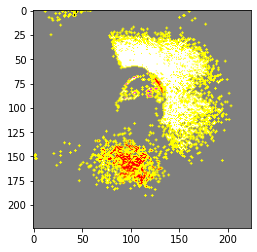

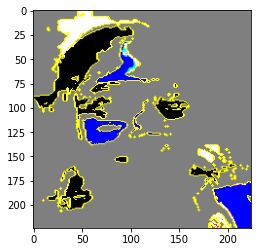

In [12]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation_1.get_image_and_mask(explanation_1.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()
temp, mask = explanation_0.get_image_and_mask(explanation_0.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

explanation 1 top labels[0] =  0


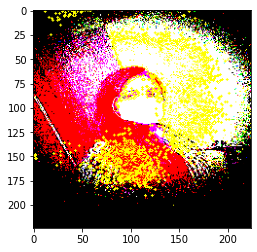

explanation 0 top labels[0] =  0


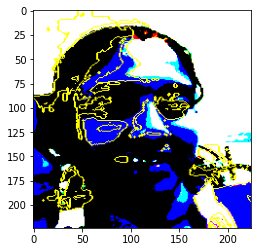

In [13]:
temp, mask = explanation_1.get_image_and_mask(explanation_1.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=False)

print('explanation 1 top labels[0] = ', explanation_1.top_labels[0])
plt.imshow(mark_boundaries(temp, mask))
plt.show()
temp, mask = explanation_0.get_image_and_mask(explanation_0.top_labels[0], 
                                            positive_only=True, 
                                            num_features=20, 
                                            hide_rest=False)

print('explanation 0 top labels[0] = ', explanation_0.top_labels[0])
plt.imshow(mark_boundaries(temp, mask))